In [1]:
from contextlib import contextmanager
from typing import Callable

import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt
from jax import jacobian, jit
from matplotlib import cm
from tabulate import tabulate

In [2]:
@contextmanager
def assert_raises(exception_type: Exception, message: str = None):
    try:
        yield
    except exception_type as e:
        if message is not None:
            assert str(e) == message
    else:
        raise AssertionError(f"{exception_type.__name__} was not raised")


def diagonally_dominant(a: np.ndarray) -> bool:
    if len(a.shape) != 2 or a.shape[0] != a.shape[1]:
        return False

    a_abs = np.abs(a)
    diag = np.diag(a_abs)
    rows_sum = np.sum(a_abs, axis=1)

    return np.all(diag > rows_sum - diag)


def do_partial_pivoting(A: np.ndarray, b: np.ndarray):
    n = A.shape[0]
    P = np.eye(n)

    for k in range(n):
        max_index = np.argmax(np.abs(A[k:, k])) + k
        if max_index != k:
            A[[k, max_index]] = A[[max_index, k]]
            P[[k, max_index]] = P[[max_index, k]]
            b[[k, max_index]] = b[[max_index, k]]

    return P, A, b


def cholesky_decomposition(A: np.ndarray):
    assert np.allclose(A, A.T), "matrix must be symmetric"
    assert np.all(np.linalg.eigvals(A) > 0), "matrix must be positive definite"

    L = np.zeros_like(A, dtype=np.float64)

    for i in range(len(A)):
        L[i, i] = np.sqrt(A[i, i] - L[i, :] @ L[i, :])

        for j in range(i + 1, len(A)):
            L[j, i] = (A[j, i] - L[i, :] @ L[j, :]) / L[i, i]

    return L


def solve_cholesky(A: np.ndarray, b: np.ndarray, partial_pivoting=False):
    if partial_pivoting:
        P, A, b = do_partial_pivoting(A, b)

    L = cholesky_decomposition(A)

    # forward substitution (Ly = b)
    y = np.zeros_like(b, dtype=np.float64)
    for i in range(len(A)):
        y[i] = (b[i] - L[i] @ y) / L[i, i]

    # backward substitution (L^T x = y)
    x = np.zeros_like(b, dtype=np.float64)
    for i in range(len(A) - 1, -1, -1):
        x[i] = (y[i] - L[i + 1 :, i] @ x[i + 1 :]) / L[i, i]

    return x


def gaussian_elimination(A: np.ndarray, b: np.ndarray, partial_pivoting=False):
    Ab = np.column_stack((A, b))
    nrows = Ab.shape[0]
    order = np.arange(nrows)

    # forward elimination
    for row in range(nrows):
        if partial_pivoting:
            max_row = abs(Ab[row:, row]).argmax() + row
            Ab[[row, max_row]] = Ab[[max_row, row]]

        for k in range(row + 1, nrows):
            if Ab[row, row] == 0:
                raise ZeroDivisionError()

            factor = Ab[k, row] / Ab[row, row]
            Ab[k] -= factor * Ab[row]

    # back substitution
    x = np.zeros(nrows)
    for row in range(nrows - 1, -1, -1):
        x[row] = (Ab[row, nrows] - np.dot(Ab[row, row + 1 : nrows], x[row + 1 : nrows])) / Ab[row, row]

    return x[order]


def lu_decomposition(A: np.ndarray):
    for i in range(1, len(A) + 1):
        assert np.linalg.det(A[:i, :i]) != 0, "matrix is singular"

    L = np.eye(len(A))
    U = np.zeros_like(L)

    for k in range(len(A)):
        U[k, k:] = A[k, k:] - L[k, :k] @ U[:k, k:]

        for i in range(k + 1, len(A)):
            if U[k, k] == 0:
                raise ZeroDivisionError()

            L[i, k] = (A[i, k] - L[i, :k] @ U[:k, k]) / U[k, k]

    return L, U


def solve_lu(A: np.ndarray, b: np.ndarray):
    L, U = lu_decomposition(A)

    # forward substitution (Ly = b)
    y = np.zeros(len(L))
    for i in range(len(y)):
        y[i] = b[i] - L[i, :i] @ y[:i]

    # backward substitution (Ux = y)
    x = np.zeros(len(U))
    for i in range(len(x) - 1, -1, -1):
        x[i] = (y[i] - U[i, i + 1 :] @ x[i + 1 :]) / U[i, i]

    return x


def lup_decomposition(A: np.ndarray):
    n = A.shape[0]

    U = A.copy()
    L = np.eye(n)
    P = np.eye(n)

    for k in range(n - 1):
        # partial pivoting
        max_row = np.argmax(np.abs(U[k:, k])) + k
        if max_row != k:
            U[[k, max_row]] = U[[max_row, k]]
            L[[k, max_row], :k] = L[[max_row, k], :k]
            P[[k, max_row]] = P[[max_row, k]]

        # elimination
        for i in range(k + 1, n):
            L[i, k] = U[i, k] / U[k, k]
            U[i, k:] -= L[i, k] * U[k, k:]

    return L, U, P


def solve_lup(A: np.ndarray, b: np.ndarray):
    L, U, P = lup_decomposition(A)

    b = P @ b
    n = A.shape[0]
    y = np.zeros(n)
    x = np.zeros(n)

    for i in range(n):
        y[i] = b[i] - np.dot(L[i, :i], y[:i])

    for i in reversed(range(n)):
        x[i] = (y[i] - np.dot(U[i, i + 1 :], x[i + 1 :])) / U[i, i]

    return x


class GaussTrail:
    def __init__(self):
        self.steps = []

    def record(self, args):
        self.steps.append(args)

    def __getitem__(self, index):
        return self.steps[index]

    def __iter__(self):
        for step in self.steps:
            yield step

    def __len__(self):
        return len(self.steps)

    def __str__(self):
        return tabulate(
            self.steps,
            floatfmt=".4f",
            showindex=True,
        )

    @property
    def result(self):
        if len(self) > 0:
            return self[-1]

    @property
    def bounds(self):
        return (min(map(min, self.steps)), max(map(max, self.steps)))

    def plot(self, F, headers, bounds=None):
        plt.subplots()

        (a, b) = self.bounds if bounds is None else bounds
        pad = (b - a) * 0.1
        x = np.arange(a - pad, b + pad, 0.01)

        x = np.linspace(a, b, 100)
        colors = cm.viridis(np.linspace(0, len(self), len(self) + len(self[0])))

        for y, header, color in zip(F(x), headers, colors):
            plt.plot(x, y, label=header, color=color)

        for i, (x, y), color in zip(range(len(self)), self, colors):
            plt.scatter(x, y, color=color)
            plt.text(x, y, i)

        plt.grid(True)
        plt.legend()
        return plt


def gauss_jacobi(A: np.ndarray, b: np.ndarray, x0: np.ndarray, tol: float = None, max_iter: int = 1000):
    # assert np.abs(np.max(np.linalg.eigvals(A))) < 1, "matrix A must be convergent"
    assert diagonally_dominant(A), "matrix A must be diagonally dominant"

    L = np.tril(A, -1)
    D = np.diag(A.diagonal())
    D_inv = np.linalg.inv(D)
    U = np.triu(A, 1)

    trail = GaussTrail()

    x = x0.copy()
    trail.record(x)

    for _ in range(max_iter):
        x_new = -D_inv @ ((U + L) @ x) + D_inv @ b

        if tol is not None and np.max(np.abs(x_new - x)) / np.max(np.abs(x_new)) < tol:
            break

        x = x_new
        trail.record(x)

    return trail


def gauss_seidel(A: np.ndarray, b: np.ndarray, tol: float = None, max_iter: int = 1000):
    # assert np.abs(np.max(np.linalg.eigvals(A))) < 1, "matrix A must be convergent"
    assert diagonally_dominant(A), "matrix A must be diagonally dominant"

    n = len(A)
    x = np.zeros_like(b)
    trail = GaussTrail()
    trail.record(x)

    for _ in range(max_iter):
        x_new = np.zeros_like(b)

        for i in range(n):
            s1 = A[i, :i] @ x_new[:i]
            s2 = A[i, i + 1 :] @ x[i + 1 :]
            x_new[i] = (b[i] - s1 - s2) / A[i, i]

        if tol is not None and np.max(np.abs(x_new - x)) / np.max(np.abs(x_new)) < tol:
            break

        x = x_new
        trail.record(x)

    return trail


class NewtonSystemTrail:
    def __init__(self, f, j):
        self.f = f
        self.j = j
        self.steps = []

    def record(self, args):
        self.steps.append(args)

    def __getitem__(self, index):
        return self.steps[index]

    def __iter__(self):
        for step in self.steps:
            yield step

    def __len__(self):
        return len(self.steps)

    def __str__(self):
        return tabulate(
            self.steps,
            floatfmt=".4f",
            showindex=True,
        )

    @property
    def result(self):
        if len(self) > 0:
            return self[-1]

    @property
    def bounds(self):
        points = [point[0] for point in self]
        return (min(points), max(points))

    def plot(self, bounds=None):
        plt.subplots()

        if bounds is None:
            bounds = self.bounds

        XS = np.meshgrid(*[np.linspace(*bounds, 40) for _ in range(len(self.steps[0]))])
        Z = [self.f(np.array(XS))[i] for i in range(len(self))]

        colors = cm.viridis(np.linspace(0, 10, len(self)))
        for i, Z0, color in zip(range(len(self)), Z, colors):
            plt.contour(*XS, Z0, levels=[0])
            x, y = self[i]
            plt.scatter(x, y, color=color, label=f"Step {i}")
            plt.text(x, y, f"Step {i}")

        plt.grid(True)
        plt.legend()
        return plt


def newton_system(F: Callable[[jnp.ndarray], jnp.ndarray], x0: jnp.ndarray, tol=1e-6, max_iter=100):
    J = jit(jacobian(F))
    trail = NewtonSystemTrail(F, J)

    x = x0.copy()
    trail.record(x)

    for _ in range(1, max_iter):
        s = jnp.linalg.solve(J(x), -F(x))

        if jnp.max(jnp.abs(s)) < tol:
            break

        x += s
        trail.record(x)

    return trail

# Exercício 1


In [3]:
A1 = np.array(
    [
        [0, 3, 2],
        [1, 4, 3],
        [0, 2, 5],
    ],
    dtype=np.float64,
)
b1 = np.array([5, 6, 7], dtype=np.float64)
s1 = (np.linalg.solve(A1, b1),)

A2 = np.array(
    [
        [-2, -2, 0],
        [1, 3, -1],
        [0, -1, 2],
    ],
    dtype=np.float64,
)
b2 = np.array([-1, 3, 1], dtype=np.float64)
s2 = (np.linalg.solve(A2, b2),)

A3 = np.array(
    [
        [1, 2, 3],
        [2, 6, 0],
        [1, 0, 4],
    ],
    dtype=np.float64,
)
b3 = np.array([4, 8, 5], dtype=np.float64)
s3 = (np.linalg.solve(A3, b3),)

# Eliminação de Gauss
with assert_raises(ZeroDivisionError):
    gaussian_elimination(A1, b1)

assert np.allclose(s1, gaussian_elimination(A1, b1, partial_pivoting=True))

assert np.allclose(s2, gaussian_elimination(A2, b2))
assert np.allclose(s2, gaussian_elimination(A2, b2, partial_pivoting=True))

assert np.allclose(s3, gaussian_elimination(A3, b3))
assert np.allclose(s3, gaussian_elimination(A3, b3, partial_pivoting=True))


# Decomposição LU
with assert_raises(AssertionError, "matrix is singular"):
    solve_lu(A1, b1)

assert np.allclose(s1, solve_lup(A1, b1))

assert np.allclose(s2, solve_lu(A2, b2))
assert np.allclose(s2, solve_lup(A2, b2))

assert np.allclose(s3, solve_lu(A3, b3))
assert np.allclose(s3, solve_lup(A3, b3))


# Cholesky
with assert_raises(AssertionError, "matrix must be symmetric"):
    solve_cholesky(A1, b1)

with assert_raises(AssertionError, "matrix must be symmetric"):
    solve_cholesky(A1, b1, partial_pivoting=True)

with assert_raises(AssertionError, "matrix must be symmetric"):
    assert np.allclose(s2, solve_cholesky(A2, b2))

with assert_raises(AssertionError, "matrix must be symmetric"):
    assert np.allclose(s2, solve_cholesky(A2, b2, partial_pivoting=True))

with assert_raises(AssertionError, "matrix must be symmetric"):
    assert np.allclose(s3, solve_cholesky(A3, b3))

with assert_raises(AssertionError, "matrix must be symmetric"):
    assert np.allclose(s3, solve_cholesky(A3, b3, partial_pivoting=True))

# Exercício 2


In [4]:
alpha = 1
A = np.array(
    [
        [1, 1, 2],
        [alpha, 1, 4],
        [5, 2, 1],
    ],
    dtype=np.float64,
)
b = np.array([-2, -3, 4], dtype=np.float64)

# a) não pode ser resolvido por LU pois tem det 0
with assert_raises(AssertionError, "matrix is singular"):
    solve_lu(A, b)

# b) não pode ser resolvido por Cholesky pois não é simétrica
with assert_raises(AssertionError, "matrix must be symmetric"):
    solve_cholesky(A, b)

# c) não pode ser resolvido por eliminação de Gauss sem pivoteamento parcial
with assert_raises(ZeroDivisionError):
    gaussian_elimination(A, b)

# mas pode ser resolvido por eliminação de Gauss com pivoteamento parcial
assert np.allclose(
    np.linalg.solve(A, b),
    gaussian_elimination(A, b, partial_pivoting=True),
)

# Exercício 3


## 3-a

### Análise da Matriz do Sistema:

- Linha 1: $|17| > |-2| + |-3|$ - Verdadeiro
- Linha 2: $|21| > |-5| + |-2|$ - Verdadeiro
- Linha 3: $|22| > |-5| + |-5|$ - Verdadeiro

### Conclusão:

Como a matriz dos coeficientes é diagonalmente dominante:

- O método de Gauss-Jacobi converge para a solução do sistema.
- O método de Gauss-Seidel converge para a solução do sistema.


In [5]:
A = np.array(
    [
        [17, -2, -3],
        [-5, 21, -2],
        [-5, -5, 22],
    ],
    dtype=np.float64,
)
b = np.array([500, 200, 30], dtype=np.float64)
x0 = np.array([34, 19, 13])

# 3-b)
assert np.allclose(
    [33.94117647, 18.85714286, 13.40909091],
    gauss_jacobi(A, b, x0, tol=0.0025, max_iter=2).result,
)
assert np.allclose(
    [33.43916176, 18.60972196, 13.19292812],
    gauss_seidel(A, b, tol=0.0025, max_iter=2).result,
)

# Exercício 4


/var/folders/39/j2g1wy9j60q08zn11dvrqdbc0000gn/T/ipykernel_95966/2139109081.py:270: RuntimeWarning: invalid value encountered in scalar divide
  if tol is not None and np.max(np.abs(x_new - x)) / np.max(np.abs(x_new)) < tol:


Text(0.05, 0.15, 'R=(0.00, 0.00)')

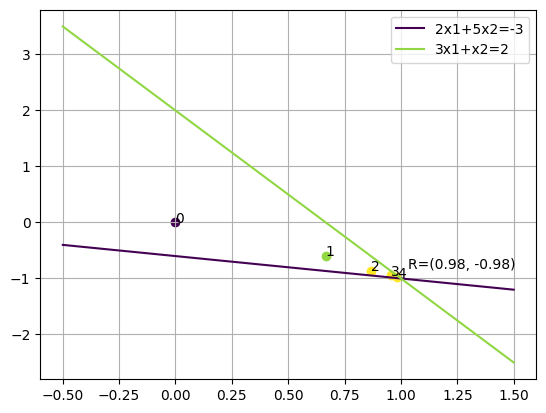

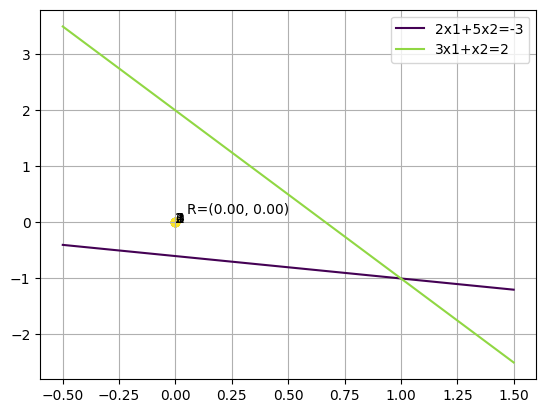

In [6]:
A = np.array([[2, 5], [3, 1]])
b = np.array([-3, 2])
x0 = np.array([0, 0])

# não é diagonalmente dominante, então não podemos usar Jacobi ou Seidel
with assert_raises(AssertionError, "matrix A must be diagonally dominant"):
    gauss_jacobi(A, b, x0)

with assert_raises(AssertionError, "matrix A must be diagonally dominant"):
    gauss_seidel(A, b)

# se trocarmos as linhas, o sistema passa a ser diagonalmente dominante
A[[0, 1]] = A[[1, 0]]
b[[0, 1]] = b[[1, 0]]

trail = gauss_jacobi(A, b, x0, tol=0.001, max_iter=4)
trail.plot(
    lambda x: np.array([(-2 * x - 3) / 5, -3 * x + 2]),
    ["2x1+5x2=-3", "3x1+x2=2"],
    bounds=(-0.5, 1.5),
)
plt.text(
    trail.result[0] + 0.05,
    trail.result[1] + 0.15,
    f"R=({trail.result[0]:.2f}, {trail.result[1]:.2f})",
)

trail = gauss_seidel(A, b, tol=0.001, max_iter=4)
trail.plot(
    lambda x: np.array([(-2 * x - 3) / 5, -3 * x + 2]),
    ["2x1+5x2=-3", "3x1+x2=2"],
    bounds=(-0.5, 1.5),
)
plt.text(
    trail.result[0] + 0.05,
    trail.result[1] + 0.15,
    f"R=({trail.result[0]:.2f}, {trail.result[1]:.2f})",
)

# Exercício 5


In [7]:
def F(x: jnp.ndarray):
    return jnp.array(
        [
            3 * jnp.sin(x[0]) - 4 * x[1] - 12 * x[2] - 1,
            4 * x[0] ** 2 - 8 * x[1] - 10 * x[2] + 5,
            2 * jnp.e ** x[0] + 2 * x[1] + 3 * x[2] - 8,
        ]
    )


x0 = jnp.array([0.0, 0.0, 0.0])

trail = newton_system(F, x0, tol=1e-3)
assert np.allclose(
    trail.result,
    opt.fsolve(F, x0),
)